In [ ]:
# !pip install sympy # !pip install pandas>=1.1.4 # !pip install seaborn>=0.11.0 # !pip install opencv-python>=4.6.0 # !pip install pandas>=1.1.4 # !pip install seaborn>=0.11.0 # !pip install filelock # !pip install networkx # !pip install opencv-python>=4.6.0 # !pip install pandas>=1.1.4 # !pip install seaborn>=0.11.0

# **Detección de Armas - Open Data**  

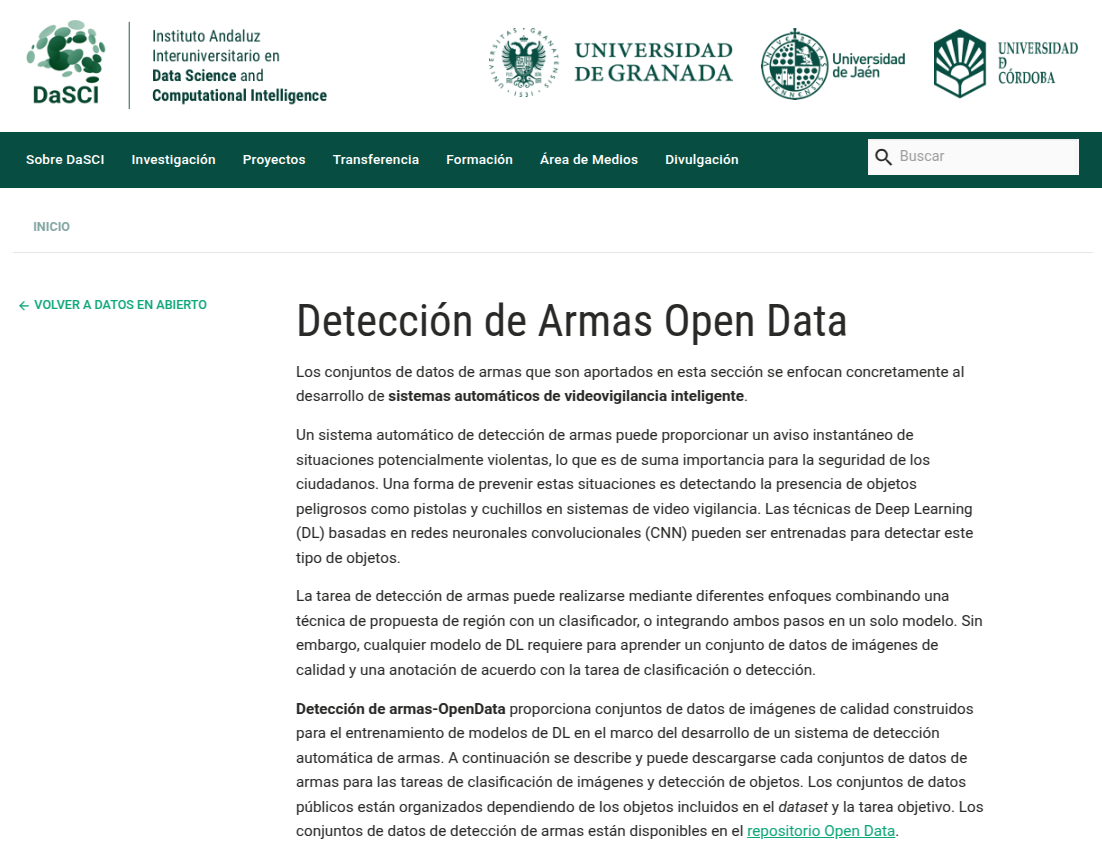

---

## Estudio del dataset

📌 [**Información del Dataset**](https://dasci.es/es/transferencia/open-data/deteccion-de-armas/)  

Este proyecto explora la aplicación de Data Augmentation mediante Diffusion Models sobre un conjunto de datos de detección de armas y otros objetos de naturaleza similar. Por ello este cuenta tanto con pistolas, cuchillos, como una cartera o billetes que los podemos coger "de manera similar" (con la mano). Nuestro objetivo es evaluar si estas técnicas pueden mejorar el rendimiento y la precisión en la tarea de detección de objetos.

Este dataset cuenta con múltiples sub-datasets, donde nos encontramos con la siguiente estructura de directorios:

    Knife_classification  License.md             Pistol_detection  Weapons_and_similar_handled_objects/
    Knife_detection       Pistol_classification  README.md         pictures

Debido a las características del problema en concreto, solo trabajaremos con la parte de Object Detection (OD), es decir, las siguientes clases:

```plaintext
📂 Weapons_and_similar_handled_objects/
 ├── 📂 Sohas_weapon-Detection-YOLOv5/
 │   ├── 📂 obj_train_data/
 │   │   ├── 📂 images/
 │   │   │   ├── train/
 │   │   │   ├── test/
 │   │   ├── 📂 labels/
 │   │   │   ├── train/
 │   │   │   ├── test/
 ├── 📂 Knife_detection/
 ├── 📂 Pistol_detection/
```

Para empezar nos centraremos en:

```plaintext
📂 Weapons_and_similar_handled_objects/
 ├── 📂 Sohas_weapon-Detection-YOLOv5/
 │   ├── 📂 obj_train_data/
```

In [1]:
data_path = "/mnt/homeGPU/azapata/TFG/datasets/gunsUGR/OD-WeaponDetection-master/Weapons_and_similar_handled_objects/Sohas_weapon-Detection-YOLOv5/obj_train_data"
images_path = "/mnt/homeGPU/azapata/TFG/datasets/gunsUGR/OD-WeaponDetection-master/Weapons_and_similar_handled_objects/Sohas_weapon-Detection-YOLOv5/obj_train_data/images/train"
labels_path = "/mnt/homeGPU/azapata/TFG/datasets/gunsUGR/OD-WeaponDetection-master/Weapons_and_similar_handled_objects/Sohas_weapon-Detection-YOLOv5/obj_train_data/labels/train"

El dataset con el que estamos trabajando cuenta con:

| Tipo   | Conjunto | Cantidad de Imágenes |
|--------|---------|-----------------|
| Images | Test    | 857             |
| Images | Train   | 5002            |
| Labels | Test    | 857             |
| Labels | Train   | 5002            |

---
## **Pipeline de Entrenamiento**

El proceso seguido en este proyecto incluye los siguientes pasos:

1. **Carga del dataset:** Se procesan las imágenes y etiquetas en formato YOLO. (Venían los archivos ya en formato YOLO, por lo que es descargarlos y hacer los data.yaml)
2. **Evaluación del modelo preentrenado:** Se usa un modelo YOLO sin ajuste para obtener un punto de referencia inicial.
3. **Fine-tuning sin Data Augmentation (DA):** Entrenamos el modelo con los datos originales.
4. **Fine-tuning con DA Clásico:** Aplicamos transformaciones como rotaciones y cambios de brillo.
5. **Fine-tuning con Modelos de Difusión:** Generamos imágenes sintéticas para mejorar la variabilidad del dataset.
6. **Fine-tuning con DA Híbrido:** Combinamos ambas técnicas para evaluar su impacto.
7. **Comparación de Resultados:** Se analizan métricas como precisión y recall para cada método.


    ***Nota:** Todos los entrenamientos de modelos se ejecutan en archivos `.py` independientes para optimizar su implementación en servidores, ya que ejecutarlos directamente en un notebook no sería eficiente.* 
---

## **Métricas de Evaluación**

Para evaluar el rendimiento del modelo, se utilizan las siguientes métricas:

- **Precisión (P)**: Proporción de verdaderos positivos sobre todas las predicciones positivas.
- **Recall (R)**: Proporción de verdaderos positivos sobre todas las instancias reales en la clase.
- **mAP@50**: Promedio de precisión cuando IoU (Intersection over Union) es al menos 50%.
- **mAP@50-95**: Promedio de precisión considerando IoU desde 50% hasta 95%.

Estas métricas permiten comparar el impacto de las distintas técnicas de Data Augmentation en la detección de objetos.

---

## 2. **Evaluación del modelo preentrenado**

Vamos a cargar YOLO preentrenado y a evaluar sin finetunning directamente y ver cómo se comporta.

(Como ya habíamos trabajado con YOLO antes y lo teníamos en local, lo cargamos directamente de nuestro dispositivo)

[Para más info](https://docs.ultralytics.com/es)

In [ ]:
# Cargar el modelo entrenado
model = YOLO("/mnt/homeGPU/azapata/TFG/runs/detect/train/weights/best.pt")  # Ruta donde se guardó el modelo entrenado

# Evaluar en el conjunto de validación
metrics = model.val(
    data="/mnt/homeGPU/azapata/TFG/datasets/gunsUGR/OD-WeaponDetection-master/Weapons_and_similar_handled_objects/Sohas_weapon-Detection-YOLOv5/dataset.yaml", 
    split="val",
    device="cuda"
)

# Mostrar métricas clave
print(f"📊 Precisión (mAP@50): {metrics.box.map50:.4f}")
print(f"📊 Precisión (mAP@50-95): {metrics.box.map:.4f}")
print(f"📊 Precisión promedio por clase: {metrics.box.maps}")


Ultralytics 8.3.73 🚀 Python-3.8.20 torch-1.7.1+cu110 CUDA:0 (NVIDIA TITAN Xp, 12196MiB)
YOLOv8l summary (fused): 268 layers, 43,668,288 parameters, 0 gradients, 165.2 GFLOPs


val: Scanning /mnt/homeGPU/azapata/TFG/datasets/gunsUGR/OD-WeaponDetection-master/Weapons_and_similar_handled_objects/Sohas_weapon-Detection-YOLOv5/obj_train_data/labels/test.


val: New cache created: /mnt/homeGPU/azapata/TFG/datasets/gunsUGR/OD-WeaponDetection-master/Weapons_and_similar_handled_objects/Sohas_weapon-Detection-YOLOv5/obj_train_data/labels/test.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 54/54 [00:19<00:00,  2.83it/s]


                   all        857        857   0.000744     0.0109   0.000387   0.000119
                person         85         85    0.00161     0.0588   0.000881   0.000378
               bicycle        140        140          0          0          0          0
                   car        452        452    0.00285    0.00664    0.00144   0.000336
            motorcycle         71         71          0          0          0          0
              airplane         52         52          0          0          0          0
                   bus         57         57          0          0          0          0
Speed: 0.7ms preprocess, 11.6ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to /mnt/homeGPU/azapata/runs/detect/val10
📊 Precisión (mAP@50): 0.0004
📊 Precisión (mAP@50-95): 0.0001
📊 Precisión promedio por clase: [ 0.00037761           0   0.0003357           0           0           0  0.00011888  0.00011888  0.00011888  0.00011888  0.00011888  0.00011888 

Como era de esperar, al no haber ajuste específico de clases, los resultados fueron deficientes.

---

## 3. **Fine-tuning sin Data Augmentation (DA):**

Para mejorar los resultados, realizamos fine-tuning con el dataset y así establecemos un **punto de partida para el resto de comparaciones con las diferentes técnicas de DA**

Vemos que esté cuda activo para poder ejecutar en GPU de los servidores.

In [2]:
!python -c "import torch; print(torch.cuda.is_available())"

!python -c "import torch; print(torch.cuda.device_count())"
!python -c "import torch; print(torch.cuda.get_device_name(0))"

!nvcc --version

True
1
NVIDIA TITAN Xp
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


Realizamos el **fine-tuning** del modelo sin utilizar ningún tipo de DA.

📂 **Ruta del script:** `/mnt/homeGPU/azapata/TFG/TrainModels/Weapons/fineTunningOG.py`

### **Resultados Fine-Tuning de YOLO con las clases del dataset original**

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 
                   all        857        857      0.848      0.789      0.886       0.73
                pistol         85         85       0.91      0.918      0.952      0.783
            smartphone        140        140      0.939      0.663      0.922      0.801
                 knife        452        452       0.97      0.903      0.973      0.676
              monedero         71         71      0.642      0.789      0.762       0.63
               billete         52         52      0.851      0.885      0.926      0.823
               tarjeta         57         57      0.777      0.579      0.782      0.665

- **Tiempo de entrenamiento:** 7 horas y 23 minutos.  

---

## 4. **Fine-tuning con DA Clásico:** 
Ahora realizamos el **fine-tuning** del modelo utilizando técnicas de **Data Augmentation clásico**.  

📂 **Ruta del script:** `/mnt/homeGPU/azapata/TFG/TrainModels/Weapons/fineTunningDAclassic.py`

### Resultado de DA Clásico
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 
                   all        857        857      0.791      0.819       0.89      0.741
                pistol         85         85      0.812      0.917       0.94      0.777
            smartphone        140        140      0.868      0.753      0.924      0.802
                 knife        452        452      0.944      0.954      0.983      0.702
              monedero         71         71      0.623      0.792      0.797      0.688
               billete         52         52      0.735      0.923       0.93      0.827
               tarjeta         57         57      0.766      0.574      0.766      0.653

- **Tiempo de entrenamiento:** 7 horas y 23 minutos.  

A pesar de haber aplicado Data Augmentation clásico, los resultados muestran una ligera disminución en el rendimiento en comparación con el modelo original. Esto sugiere que este enfoque de DA no ha sido efectivo para este dataset en particular, al menos en la forma en que se implementó.

---

## 5. **Fine-tuning con Modelos de Difusión:** 
Ahora realizamos el **fine-tuning** del modelo utilizando técnicas de **Data Augmentation con modelos de difusión**.  

📂 **Ruta del script:** `/mnt/homeGPU/azapata/TFG/TrainModels/Weapons/fineTunningDADM.py`

### Resultado DA con modelos de difusión
               Class     Images  Instances      Box(P          R      mAP50  mAP50-95):
                   all        857        857      0.839      0.839      0.903      0.757
                pistol         85         85      0.871      0.871      0.943      0.789
            smartphone        140        140      0.957      0.804       0.94      0.812
                 knife        452        452      0.965      0.938      0.979      0.705
              monedero         71         71      0.708       0.82      0.812      0.712
               billete         52         52      0.773      0.885      0.935      0.847
               tarjeta         57         57      0.758      0.714      0.811      0.679

- **Tiempo de generación de datos adicionales:** 1 día, 9 horas y 15 minutos.  
- **Tiempo de entrenamiento:** 13 horas y 15 minutos.  
- **Cantidad de imágenes originales:** 89,445.  
- **Tamaño del dataset tras Data Augmentation:** 195,199 imágenes.  
- **Imágenes generadas:** 105754, con una nueva imagen cada 1,13 segundos.  

Si bien los resultados muestran una mejora con respecto al fine-tuning utilizando **DA clásico**, aún no superan el rendimiento del modelo base.

---

## 6. **Fine-tuning con DA Híbrido:**
Ahora realizamos el **fine-tuning** del modelo utilizando técnicas de **Data Augmentation con modelos de difusión y DA clásico sobre este dataset mejorado**.  

📂 **Ruta del script:** `/mnt/homeGPU/azapata/TFG/TrainModels/Weapons/fineTunningHibrid.py`

### Resultado DA hibrido 👑

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 
                   all        857        857      0.868      0.839      0.911      0.769
                pistol         85         85      0.871      0.918      0.942      0.797
            smartphone        140        140      0.982       0.75      0.948      0.819
                 knife        452        452      0.975      0.932      0.984      0.715
              monedero         71         71      0.704      0.817      0.791      0.691
               billete         52         52      0.874      0.904      0.961      0.869
               tarjeta         57         57      0.803      0.716      0.841      0.721

- **Tiempo de entrenamiento:** 14 horas y 7 minutos.  
- **Hay que tener en cuenta que tuvimos que generar los datos para DA DM**
---

## 7. **Comparación de Resultados:** 

Tras realizar el **fine-tuning** del modelo utilizando distintas técnicas de **Data Augmentation**, analizamos y comparamos sus resultados en términos de **precisión (P)**, **recall (R)** y métricas de **mAP (Mean Average Precision)**.  

#### 📊 **Resumen de los Resultados**  

| Técnica de Entrenamiento | mAP@50 | mAP@50-95 | Precisión (P) | Recall (R) | Tiempo de Entrenamiento |
|-------------------------|--------|----------|--------------|----------|------------------|
| **Fine-Tuning sin DA**  | 0.886  | 0.730    | 0.848        | 0.789    | 7h 23m           |
| **DA Clásico**          | 0.890  | 0.741    | 0.791        | 0.819    | 7h 23m           |
| **Modelos de Difusión** | 0.903  | 0.757    | 0.839        | 0.839    | 13h 15m          |
| **DA Híbrido** 👑       | 0.911  | 0.769    | 0.868        | 0.839    | 14h 7m           |

---

### 🔍 **Análisis de los Resultados**  

1. **Fine-Tuning sin DA (Baseline)**  
   - Este modelo sirvió como referencia inicial para evaluar el impacto de los distintos métodos de DA.  
   - **mAP@50-95** = **0.730**, lo que representa el desempeño base del modelo sin técnicas adicionales de mejora de datos.  

2. **DA Clásico (Transformaciones Convencionales)**  
   - Se aplicaron transformaciones como rotaciones, cambios de brillo y escalado.  
   - Aunque hubo una ligera mejora en **mAP@50-95** (+0.011), la precisión general se redujo en comparación con el modelo sin DA.  
   - **Conclusión:** No fue una estrategia efectiva en este dataset.  

3. **Data Augmentation con Modelos de Difusión (DA DM)**  
   - Se generaron **105,754 imágenes sintéticas**, lo que incrementó el dataset de **89,445 a 195,199 imágenes**.  
   - **mAP@50-95** subió a **0.757**, mostrando una mejora respecto al DA clásico.  
   - **Conclusión:** El uso de modelos generativos ayudó a mejorar la generalización del modelo.  

4. **Data Augmentation Híbrido (DA Clásico + Modelos de Difusión)**  
   - Se combinó el **DA clásico con modelos de difusión**, aprovechando ambas estrategias.  
   - **mAP@50-95** alcanzó **0.769**, la mejor puntuación obtenida.  
   - **Conclusión:** Esta combinación resultó ser la más efectiva, logrando el mejor balance entre precisión y recall.  

---

### 🏆 **Conclusión Final**  

- **El Data Augmentation Clásico no fue efectivo** en este dataset, ya que redujo la precisión y no mostró una mejora significativa en recall.  
- **Los Modelos de Difusión ayudaron a mejorar la detección**, pero su impacto no fue suficiente para superar el baseline por un margen significativo.  
- **El mejor enfoque fue el DA Híbrido**, combinando ambas técnicas, lo que permitió alcanzar **la mejor precisión y recall** en la tarea de detección de armas y objetos similares. 